# Architecture
<img src="https://miro.medium.com/max/2992/0*KEmfTtghsCDu6UTb.png" width="400">



In [ ]:
import os
import collections
import torch
import torch.nn as nn
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

from glob import glob
from os.path import join
from os import listdir
from pathlib import Path


from torch import optim
import torchvision
from torchvision import transforms
import torchvision.utils as vutils
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from torch.nn.modules.loss import L1Loss
from torch.nn.modules.loss import MSELoss
from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def numpy_from_tensor(x):
  return x.detach().cpu().numpy()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


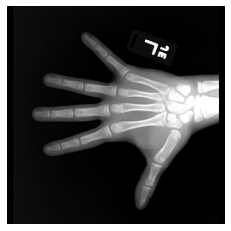

In [ ]:
class NiftyDataset(Dataset):
  '''
    Class that loads nii files, resizes them to 96x96 and feeds them
  '''
  def __init__(self,root_dir, transform=None):
    '''
      root_dir - string - path towards the folder containg the data
    '''
    # Save the root_dir as a class variable
    self.root_dir = root_dir
    # Save the filenames in the root_dir as a class variable
    self.filenames = listdir(self.root_dir)
    self.filenames = [file for file in self.filenames if file.endswith('.gz')]
    self.transform = transform

  def __len__(self):
    return len(self.filenames)

  def __getitem__(self,idx):
    # Fetch file filename
    img_name = self.filenames[idx]
    # Load the nifty image
    img = nib.load(os.path.join(self.root_dir,img_name))
    # Get the voxel values as a numpy array
    img = np.array(img.get_fdata())
    # Expanding the array with 1 new dimension as feature channel
    img = np.expand_dims(img, 0).astype(np.float32)

    if self.transform:
      img = self.transform(np.transpose(img, (1, 2, 0)))
    return img

transform=transforms.Compose([
                              transforms.ToPILImage(),
                              transforms.Grayscale(num_output_channels=1),
                              transforms.Resize((28,28)),
                              # transforms.RandomHorizontalFlip(p=0.5),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5,),(0.5,))
])

norm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

tensor=transforms.ToTensor()

flip_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.RandomHorizontalFlip(0.5),
                                      transforms.RandomVerticalFlip(0.5)
])

# Loading the data
dataset = NiftyDataset(
    root_dir=join('/content/drive/MyDrive/nii'),
    transform=tensor
)

# Create the required DataLoaders for training and testing
dataset_loader = DataLoader(
    dataset,
    shuffle=True,
    batch_size=4,
    num_workers=4,
    drop_last=True
)

# Show a random image from training
plt.imshow(np.squeeze(next(iter(dataset))), cmap="gray")
plt.axis('off')
plt.show()

# Encoder & Decoder


In [ ]:
# Auxiliary module to flatten output
class Flatten(nn.Module):
  def forward(self, input):
    return input.view(input.size(0), -1)

# Auxiliary module to expand dims for Decoder
class Unflatten(nn.Module):
    def forward(self, input, size=512):
      return input.view(input.size(0), size, 2, 2)

# Auxiliary Module to trim Decoder output dimensions (to adjust for extra padding)
class Trim(nn.Module):
  def __init__(self, *args):
    super().__init__()
  def forward(self, x):
    return x[:, :, :256, :256]


class Encoder(nn.Module):
  def __init__(self, device,
              in_channels = (1, 8, 16, 32, 64, 128, 256),
              out_channels = (8, 16, 32, 64, 128, 256, 512),
              kernel_sizes = (4, 4, 4, 4, 4, 4, 4),
              strides = (2, 2, 2, 2, 2, 2, 2),
              paddings = (1, 1, 1, 1, 1, 1, 1),
              activation=nn.ReLU,
              batch_norm=True,
              *args, **kwargs):
    super(Encoder,self).__init__()

    self.device = device

    # Create sequential model
    self.layers = []
    for i in range(len(in_channels)):
        self.layers.append(nn.Conv2d(in_channels[i], out_channels[i],
                                    kernel_size=kernel_sizes[i],
                                    stride=strides[i],
                                    padding=paddings[i],
                                    bias=not batch_norm))
        # Add batch normalisation
        if batch_norm:
            self.layers.append(nn.BatchNorm2d(out_channels[i]))
        # Add activation
        self.layers.append(activation())
    # Flatten final layer to hidden dimension
    self.layers.append(Flatten())

    self.encode = nn.Sequential(*self.layers)

    # self.initialize_weights(self.encode)

  def forward(self,x):
    h = self.encode(x)
    # dim [-1, 2048]
    return h

  def initialize_weights(self, module):
    if isinstance(module, nn.Linear) or isinstance(module, nn.Conv2d):
      torch.nn.init.xavier_normal_(module.weight.data)



class Decoder(nn.Module):
  def __init__(self, device,
              in_channels = (512, 256, 128, 64, 32, 16, 8),
              out_channels = (256, 128, 64, 32, 16, 8, 1),
              kernel_sizes = (4, 4, 4, 4, 4, 4, 6),
              strides = (2, 2, 2, 2, 2, 2, 2),
              paddings = (1, 1, 1, 1, 1, 1, 1),
              activation=nn.ReLU,
              out_activation=nn.Tanh,
              batch_norm=True,
              lr=1e-5,
              *args, **kwargs):
    super(Decoder, self).__init__()

    self.device = device

    # Add layers
    self.layers = []
    self.layers.append(Unflatten())
    for i in range(len(in_channels)):
        self.layers.append(nn.ConvTranspose2d(in_channels[i], out_channels[i],
                                                      kernel_size=kernel_sizes[i],
                                                      stride=strides[i],
                                                      padding=paddings[i],
                                                      bias=not batch_norm))
        if i != len(in_channels) - 1:
            # only batch norm and activation for middle layers
            if batch_norm:
                self.layers.append(nn.BatchNorm2d(out_channels[i]))
            self.layers.append(activation())
    # Trim dims in case of extra padding
    self.layers.append(Trim())
    self.layers.append(out_activation())

    self.decode = nn.Sequential(*self.layers)

    # self.initialize_weights(self.decode)

  def forward(self,x):
    # x dim: [-1, 2048] -> [-1, 1, 256, 256]
    return self.decode(x)

  def initialize_weights(self, module):
    if isinstance(module, nn.Linear) or isinstance(module, nn.Conv2d):
      torch.nn.init.xavier_normal_(module.weight.data)

# Adversarial Learning (discriminator)

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator,self).__init__()

    # Convs
    self.conv1 = nn.Conv2d(1,8,5,padding=2,stride=1, bias=False)
    self.conv2 = nn.Conv2d(8,32,5,padding=2,stride=2, bias=False)
    self.bn1 = nn.BatchNorm2d(32,momentum=0.9)
    self.conv3=nn.Conv2d(32,64,5,padding=2,stride=2, bias=False)
    self.bn2=nn.BatchNorm2d(64,momentum=0.9)
    self.conv4=nn.Conv2d(64,64,5,padding=2,stride=2, bias=False)
    self.bn3=nn.BatchNorm2d(64,momentum=0.9)

    # Linear
    self.fc1=nn.Linear(65536,128)
    self.bn4=nn.BatchNorm1d(128,momentum=0.9)
    self.fc2=nn.Linear(128,1)

    # Activations
    self.relu=nn.LeakyReLU(0.2)
    self.sigmoid=nn.Sigmoid()

    # self.maxpool = nn.MaxPool2d(kernel_size=5, stride=2, padding=1)

    torch.nn.init.xavier_normal_(self.conv1.weight.data)
    torch.nn.init.xavier_normal_(self.conv2.weight.data)
    torch.nn.init.xavier_normal_(self.conv3.weight.data)
    torch.nn.init.xavier_normal_(self.conv4.weight.data)
    torch.nn.init.xavier_normal_(self.fc1.weight.data)
    torch.nn.init.xavier_normal_(self.fc2.weight.data)

  def forward(self,x):
    x=self.relu(self.conv1(x))
    x=self.relu(self.bn1(self.conv2(x)))
    x=self.relu(self.bn2(self.conv3(x)))
    x=self.relu(self.bn3(self.conv4(x)))
    x=x.view(4,-1)
    x_feats=x
    x=self.relu(self.bn4(self.fc1(x)))
    x=self.sigmoid(self.fc2(x))
    return x,x_feats

In [ ]:
discriminator = Discriminator().to(device)

# Code Processor and Network

In [ ]:
class DenseCodeProcessor(nn.Module):
  def __init__(self, device, is_training=True, h_dim=512*2*2, z_dim=512):
    super(DenseCodeProcessor, self).__init__()

    self.is_training = is_training
    self.device = device

    # Linear layers for hidden -> latent space
    self.fc_mu = nn.Linear(h_dim, z_dim)
    self.fc_logvar = nn.Linear(h_dim, z_dim)

    # Linear layer for latent -> image space
    self.fc_decode = nn.Linear(z_dim, h_dim)

    self.initialize_weights(self.fc_mu)
    self.initialize_weights(self.fc_logvar)
    self.initialize_weights(self.fc_decode)

  def forward(self, x):
    # h dim: 2048 -> 512
    mu, logvar = self.fc_mu(x), self.fc_logvar(x)
    return mu, logvar

  def decode(self, x):
    # x dim: 512 -> 2048
    return self.fc_decode(x)

  def set_is_training(self, is_training):
    self.is_training = is_training

  def initialize_weights(self, module):
    if isinstance(module, nn.Linear) or isinstance(module, nn.Conv2d):
      torch.nn.init.xavier_normal_(module.weight.data)



class VAE_GAN(nn.Module):
  def __init__(self, device, is_training=True):
    super(VAE_GAN, self).__init__()

    self.is_training = is_training
    self.device = device

    self.encoder=Encoder(device=self.device)
    self.decoder=Decoder(device=self.device)
    self.code_processor = DenseCodeProcessor(device=self.device, is_training=self.is_training)
    self.discriminator=Discriminator()

  def forward(self, x):
    # clone input
    orig = x
    # encode
    h = self.encoder(x)
    # process code
    mu, logvar = self.code_processor(h)
    logvar = torch.clamp(logvar, min=-50.0, max=50.0)
    # reparameterize
    std = logvar.mul(0.5).exp_()
    eps = torch.randn(*mu.size(), requires_grad=True).to(self.device)
    z = mu + std*eps

    # decode and gen
    x_tilda = self.code_processor.decode(z) if self.is_training else self.code_processor.decode(mu)
    x_tilda = self.decoder(x_tilda)

    # if training, x_tilda is the reparameterized reconstruction otherwise it is reconstruction of mu
    return mu, logvar, x_tilda

  def set_is_training(self, is_training):
    self.is_training = is_training
    self.code_processor.set_is_training(is_training)

# Training Loop

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def plot(model,n=5):
    model.eval()
    plt.figure(figsize=(10,4.5))
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = dataset[i].unsqueeze(0).to(device)
      with torch.no_grad():
         _, _, rec_img = model(img)
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()

In [ ]:
from easydict import EasyDict as edict

vaegan = VAE_GAN(device=device)
vaegan.to(device)

epochs = 50
lr = 1e-4
beta = 5
gamma = 80

bce = nn.BCELoss().to(device)

optimizers = edict()
optimizers.encoder = torch.optim.RMSprop(vaegan.encoder.parameters(), lr=lr)
optimizers.decoder = torch.optim.RMSprop(vaegan.decoder.parameters(), lr=lr)
optimizers.discriminator = torch.optim.RMSprop(vaegan.discriminator.parameters(), lr=lr*0.1)

# Constants (batch_size, 1)
ONES = torch.ones(4,1).to(device)
ZEROS = torch.zeros(4,1).to(device)
ZEROS_ =torch.zeros(4,1).to(device)

for epoch in range(epochs):

  # Track losses
  track_kld = []
  track_gan = []
  track_recon = []

  vaegan.set_is_training(True)
  vaegan.train()

  for i, data in enumerate(dataset_loader, 0):

    data = data.float().to(device)

    # Forward VAE
    mu, logvar, recon = vaegan(data)
    z_sample = torch.randn(4,512).to(device)
    x_fake = vaegan.decoder(vaegan.code_processor.decode(z_sample))

    # Eval adverserial
    out, _ = vaegan.discriminator(data)
    error_Dis_real = bce(out, ONES)
    out, _ = vaegan.discriminator(recon)
    error_Dis_recon= bce(out, ZEROS)
    out, _ = vaegan.discriminator(x_fake)
    error_Dis_fake = bce(out, ZEROS_)
    gan_loss = error_Dis_real + error_Dis_recon + error_Dis_fake
    track_gan.append(gan_loss.item())
    optimizers.discriminator.zero_grad()
    # Backprop dis
    gan_loss.backward(retain_graph=True)
    optimizers.discriminator.step()

    # Repeat for updated discriminator
    out, _ = vaegan.discriminator(data)
    error_Dis_real = bce(out, ONES)
    out, _ = vaegan.discriminator(recon)
    error_Dis_recon = bce(out, ZEROS)
    out, _ = vaegan.discriminator(x_fake)
    error_Dis_fake = bce(out, ZEROS_)
    gan_loss = error_Dis_real + error_Dis_recon + error_Dis_fake

    # Eval reconstruction
    _, x_feats = vaegan.discriminator(data)
    _, x_feats_recon = vaegan.discriminator(recon)
    recon_loss = ((x_feats_recon - x_feats) ** 2).mean() # MSE
    error_decoder = gamma * recon_loss - gan_loss
    track_recon.append(recon_loss.item())
    # Backprop dec
    optimizers.decoder.zero_grad()
    error_decoder.backward(retain_graph=True)
    optimizers.decoder.step()

    mu, logvar, recon = vaegan(data)
    _, x_feats = vaegan.discriminator(data)
    _, x_feats_recon = vaegan.discriminator(recon)
    recon_loss = ((x_feats_recon - x_feats) ** 2).mean()
    kld = 1 + logvar - mu.pow(2) - logvar.exp()
    kld = (-0.5 * torch.sum(kld))/(4*512)
    track_kld.append(kld.item())
    error_encoder = kld + beta*recon_loss
    # Backprop enc
    optimizers.encoder.zero_grad()
    error_encoder.backward()
    optimizers.encoder.step()

    if i % 50 == 0:
      print(f"Epoch: {epoch}, GAN Loss: {gan_loss.item()}, KLD: {kld.item()}, Reconstruction Loss: {recon_loss.item()}")

  plot(vaegan)



# Reconstruction Visualisation & Metrics

Image 0 MSE: 6417.6767578125
Image 1 MSE: 5298.19091796875
Image 2 MSE: 4385.2744140625
Image 3 MSE: 4279.46142578125
Image 4 MSE: 6335.775390625


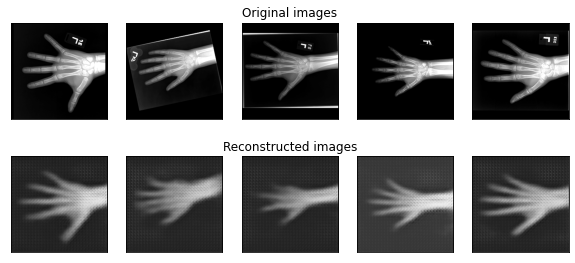

In [ ]:
vaegan.eval()
vaegan.set_is_training(True)
plt.figure(figsize=(10,4.5))
for i in range(5):
  ax = plt.subplot(2,5,i+1)
  img = dataset[i].unsqueeze(0).to(device)
  with torch.no_grad():
    _, _, rec_img = vaegan(img)
  plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  if i == 5//2:
    ax.set_title('Original images')
  ax = plt.subplot(2, 5, i + 1 + 5)
  plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  if i == 5//2:
      ax.set_title('Reconstructed images')
  mse = ((rec_img - img) ** 2).mean()
  print(f"Image {i} MSE: {mse}")
plt.show()

# Comparison to standard VAE (without the GAN loss)

Image 0 MSE: 6397.01953125
Image 1 MSE: 5272.1171875
Image 2 MSE: 4366.2275390625
Image 3 MSE: 4269.8369140625
Image 4 MSE: 6314.291015625


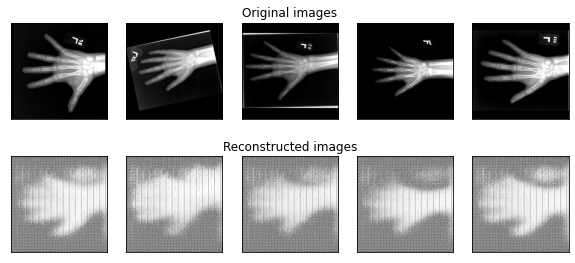

In [ ]:
vae = VAE_GAN(device=device).to(device)
vae.to(device)

epochs = 5
lr = 1e-5

optimizer = torch.optim.Adam(vae.parameters(), lr=lr)

for epoch in range(epochs):
  vae.train()
  vae.set_is_training(True)
  for data in dataset_loader:
    data = data.float().to(device)
    mu, logvar, recon = vae(data)
    mse_loss = ((recon - data) ** 2).mean()
    kld_loss = (-0.5 * torch.sum((1 + logvar - mu.pow(2) - logvar.exp())))/torch.numel(mu.data)
    loss = mse_loss + kld_loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

vae.eval()
vae.set_is_training(True)
plt.figure(figsize=(10,4.5))
for i in range(5):
  ax = plt.subplot(2,5,i+1)
  img = dataset[i].unsqueeze(0).to(device)
  with torch.no_grad():
    _, _, rec_img = vae(img)
  plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  if i == 5//2:
    ax.set_title('Original images')
  ax = plt.subplot(2, 5, i + 1 + 5)
  plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  if i == 5//2:
      ax.set_title('Reconstructed images')
  mse = ((rec_img - img) ** 2).mean()
  print(f"Image {i} MSE: {mse}")
plt.show()

# Generate Samples

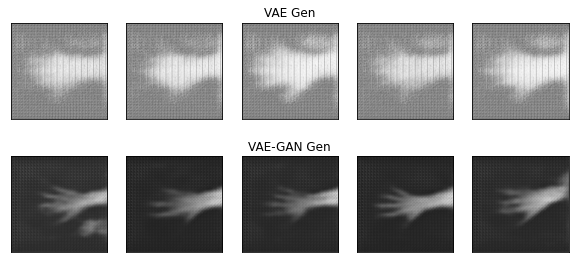

In [ ]:
vaegan.eval()
vaegan.set_is_training(True)
vae.eval()
vae.set_is_training(True)
plt.figure(figsize=(10,4.5))
for i in range(5):
  ax = plt.subplot(2,5,i+1)
  img = torch.randn(1, 512).to(device)
  img = vaegan.decoder(vaegan.code_processor.decode(img))
  with torch.no_grad():
    _, _, rec_vgan = vaegan(img)
    _, _, rec_vae = vae(img)
  plt.imshow(rec_vae.cpu().squeeze().numpy(), cmap='gist_gray')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  if i == 5//2:
    ax.set_title('VAE Gen')
  ax = plt.subplot(2, 5, i + 1 + 5)
  plt.imshow(rec_vgan.cpu().squeeze().numpy(), cmap='gist_gray')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  if i == 5//2:
      ax.set_title('VAE-GAN Gen')
plt.show()